In [30]:
%matplotlib inline

In [31]:
pwd

'/home/andre/Projects/stocks/data'

In [32]:
cd stocks/

[Errno 2] No such file or directory: 'stocks/'
/home/andre/Projects/stocks/data


In [33]:
cd ..

/home/andre/Projects/stocks


In [34]:
%matplotlib inline
from matplotlib import pylab as plt

In [35]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from Tools.util import progressbar
from Tools import meta5Ibov 
from Tools.backtest import stester
from scipy import stats
import talib as ta

In [36]:
cd data

/home/andre/Projects/stocks/data


In [37]:
datapath = r'/home/andre/Projects/stocks/data'
meta5Ibov.setDataPath(datapath, datapath, verbose=False)
meta5Ibov.loadMeta5Data()
prices = meta5Ibov.getSymbol("PETR4")

Master data loaded size (minutes):  505242
Symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']
Using previous loaded data!


In [38]:
X, lag, clip = prices[['C']].copy(), 71, 0.90

In [39]:
X["y"] = np.nan
X["ema"] = ta.EMA(X.C.values, lag)
X.loc[ X.C > X.ema, 'y'] = 1
X.loc[ X.C < X.ema, 'y'] = 0
X.y = X.y.shift(-lag) 
y = X.y.dropna()    
Yn = pd.DataFrame(index=y.index)
Yn['dir'] = y.values

In [40]:
# # 30% wrong predictions insert
# rand=.3
# # include the percentage of random samples
# wrongp = np.random.randint(0, len(Yn), int(len(Yn)*rand))
# wrongv = np.random.randint(0, 2, int(len(Yn)*rand))
# Yn.iloc[wrongp, 0] = wrongv

In [41]:
# calculate decision cut-off 
sumy = np.convolve(Yn.dir.values, np.ones(lag), mode='valid')
sumy = np.concatenate((np.ones(lag)*np.nan, sumy))[:-1]
Yn['ysum'] = sumy
Yn['dir'] = np.nan # direction up/down based on cut-off
Yn.loc[Yn.ysum > clip*lag, 'dir'] = 1
Yn.loc[Yn.ysum <= (1.-clip)*lag, 'dir'] = -1
#Yn = prepareData.removedayBorders(Yn, int(lag)) not trainning anything
Yn.dropna(inplace=True) # in any case
Yn.drop(columns=['ysum'], inplace=True)    

In [42]:
Yn.head(3)

,dir
time,
2013-07-01 14:12:00,1.0
2013-07-01 14:13:00,1.0
2013-07-01 14:14:00,1.0


In [43]:
prices.head(3)

,O,H,L,C,TV,RV
time,,,,,,
2013-07-01 10:06:00,15.23,15.27,15.22,15.27,74,36800
2013-07-01 10:07:00,15.27,15.27,15.22,15.22,58,65300
2013-07-01 10:08:00,15.22,15.23,15.21,15.21,24,17000


In [44]:
len(Yn)

172354

In [45]:
import importlib

In [46]:
importlib.reload(stester)

<module 'Tools.backtest.stester' from '/home/andre/Projects/stocks/Tools/backtest/stester.py'>

In [47]:
strategytester = stester.strategyTester(prices, Yn)
# 20 random cenarios 6 months no need to discount for border removal
ssize = 6*22*7*60 # scenario size
strategytester.setupScenarios(ssize, True) # calculate number of possible scenarios
#for i in np.random.randint(0, strategytester.nscenarios, 10):

number of possible scenarios 152436


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

152436

Make 100% correct vector Yn  
by checking the price after 90 minutes

In [82]:
%%time
strategytester.Simulate(50000., 8, 2, 60, -666, 0.035, 90, riskap=0.05) 

CPU times: user 579 ms, sys: 335 ms, total: 914 ms
Wall time: 521 ms


In [83]:
strategytester.avgAccuracy()

0.8599418040737148

In [84]:
strategytester.sortina()

25.85937128088283

In [85]:
strategytester.drawDown()

-0.0012799999999999478

In [87]:
strategytester.avgOrdersDay()

4.14722445695897

Backtesting engine graphs include here.
Include code on backtest.py

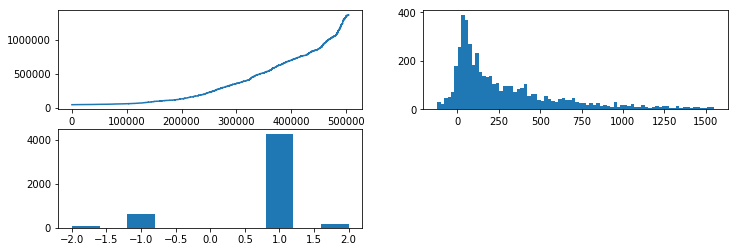

In [88]:
plt.figure(figsize=(12,4))
plt.subplot(221)
plt.plot(strategytester.money)
orders = strategytester.orders
orders['DM'] = (orders.QT*orders.CP-orders.QT*orders.EP)*orders.DR
plt.subplot(222)
plt.hist(orders.DM, bins=80, range=np.percentile(orders.DM, [4, 96]));
plt.subplot(223)
plt.hist(orders.SS);

In [ ]:
for i in np.random.randint(0, strategytester.nscenarios, 1):
    strategytester.Scenario(i, ssize, 50000., 10, 2, 60, 300, 0.06, 90)                      

In [ ]:
f = sns.factorplot('sortinoc', 'clip', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()

In [ ]:
f = sns.factorplot('sortinoc', 'lag', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()

In [ ]:
f = sns.factorplot('sortinoc', 'mprof', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()

In [ ]:
f = sns.factorplot('sortinoc', 'exvar', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()